In [19]:
import numpy as np
import tensorflow as tf
import tensornets as nets
import os
from PIL import Image
from tqdm import tqdm, tqdm_notebook
import pickle
import math
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt

### Implementation Guide:  
- [X] Read In Images  
- [ ] Create Labels
- [ ] Split data into training and validation- 
- [ ] Load in Model
- [ ] Change last layer of model
- [ ] Manipulate images to fit model
- [ ] Train Model with new data
- [ ] Validate Perfomance
- [ ] Save Model
- [ ] Write function to classify 1 image

### Reading Images From File

In [2]:
classes = ["Can", "Cookies", "Eggs", "Empty", "Fruit"]
dataDict = {classID: [] for classID in classes}
img_dir = "./Classes/"
for classID in tqdm_notebook(classes):
    path = img_dir + classID
    images = os.listdir(path)
    #print(len(images), classID)
    for image in tqdm_notebook(images):
        pic = Image.open(os.path.join(path,image))
        pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
        dataDict[classID] = dataDict[classID] + [pix]
    

KeyboardInterrupt: 

### Splitting into train and validate

In [41]:
def one_hot_encode(x):
    classEncoder = {classID:i for (i, classID) in enumerate(classes)}
    encoded = np.zeros((len(x), 5))
    
    for idx, val in enumerate(x):
        encoded[idx][classEncoder[val]] = 1
        
    return encoded


In [42]:
def train_validate_split(validfrac = .1):
    valid_features = []
    valid_labels = []
    train_features = []
    train_labels = []
    for classID in tqdm(classes):
        num_images = len(dataDict[classID])
        validIdx = math.ceil(num_images*validfrac)
        valid_features.extend(dataDict[classID][:validIdx])
        valid_labels.extend([classID]*validIdx)
        train_features.extend(dataDict[classID][validIdx:])
        train_labels.extend([classID]*(num_images-validIdx))
    return (valid_features, valid_labels, train_features, train_labels)

(valid_features, valid_labels, train_features, train_labels) = train_validate_split()
one_hot_valid = one_hot_encode(valid_labels)
one_hot_train = one_hot_encode(train_labels)
print(len(valid_features), len(valid_labels))
print(len(train_features), len(train_labels))

        
        
        
    
    

100%|██████████| 5/5 [00:00<00:00, 21334.20it/s]

29 29
240 240


In [3]:
def _preprocess_and_save(features, labels, filename):
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data():
    n_batches = 15
    
    (valid_features, valid_labels, train_features, train_labels) = train_validate_split()
    
    batchLen = math.floor(len(valid_features)/n_batches)
    for batch_i in range(1, n_batches + 1):
        features = train_features[(batch_i-1)*batchLen:(batch_i*batchLen)]
        labels = train_labels[(batch_i-1)*batchLen:(batch_i*batchLen)]
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(features, labels, 
                             'preprocess_batch_' + str(batch_i) + '.p')
    _preprocess_and_save(np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')
    _preprocess_and_save(np.array(valid_features), np.array(valid_labels),
                         'preprocess_testing.p')



In [68]:
preprocess_and_save_data()

100%|██████████| 5/5 [00:00<00:00, 20400.31it/s]


## INPUT and OUTPUT tensors

In [4]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [5]:
x = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 5), name='output_y')



In [6]:
### HYPER-PARAMETERS
learning_rate = 0.00001
epochs = 16
batch_size = 16

In [7]:
logits = nets.VGG19(x, is_training=True, classes=5)
model = tf.identity(logits,name='logits')
loss = tf.losses.softmax_cross_entropy(y,logits)
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
logits.print_outputs()

Scope: vgg19
conv1/1/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/1/Relu:0 (?, 224, 224, 64)
conv1/2/conv/BiasAdd:0 (?, 224, 224, 64)
conv1/2/Relu:0 (?, 224, 224, 64)
conv1/pool/MaxPool:0 (?, 112, 112, 64)
conv2/1/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/1/Relu:0 (?, 112, 112, 128)
conv2/2/conv/BiasAdd:0 (?, 112, 112, 128)
conv2/2/Relu:0 (?, 112, 112, 128)
conv2/pool/MaxPool:0 (?, 56, 56, 128)
conv3/1/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/1/Relu:0 (?, 56, 56, 256)
conv3/2/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/2/Relu:0 (?, 56, 56, 256)
conv3/3/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/3/Relu:0 (?, 56, 56, 256)
conv3/4/conv/BiasAdd:0 (?, 56, 56, 256)
conv3/4/Relu:0 (?, 56, 56, 256)
conv3/pool/MaxPool:0 (?, 28, 28, 256)
conv4/1/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/1/Relu:0 (?, 28, 28, 512)
conv4/2/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/2/Relu:0 (?, 28, 28, 512)
conv4/3/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/3/Relu:0 (?, 28, 28, 512)
conv4/4/conv/BiasAdd:0 (?, 28, 28, 512)
conv4/4/Relu:0 (?, 28, 28, 5

In [9]:
logits.print_summary()

Scope: vgg19
Total layers: 19
Total weights: 114
Total parameters: 418,772,175


In [10]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [11]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))
    
    tmpFeatures = []
    
    for feature in features:
        tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
        tmpFeatures.append(tmpFeature)

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(tmpFeatures, labels, batch_size)

In [12]:
tmpValidFeatures = []

for feature in valid_features:
    tmpValidFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpValidFeatures.append(tmpValidFeature)
    
tmpValidFeatures = np.array(tmpValidFeatures)

/home/arash/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/arash/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [13]:
print(tmpValidFeatures.shape)

(29, 224, 224, 3)


In [14]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    print('global_variables_initializer ... done ...')
    sess.run(logits.pretrained())
    print('model.pretrained ... done ... ')    
    
    # Training cycle
    print('starting training ... ')
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(train, {x: batch_features, y: batch_labels})
                
            print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
            
            # calculate the mean accuracy over all validation dataset
            valid_acc = 0
            for batch_valid_features, batch_valid_labels in batch_features_labels(tmpValidFeatures, valid_labels, batch_size):
                valid_acc += sess.run(accuracy, {x:batch_valid_features, y:batch_valid_labels})
            
            tmp_num = tmpValidFeatures.shape[0]/batch_size
            print('Validation Accuracy: {:.6f}'.format(valid_acc/tmp_num))
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)


Training...
global_variables_initializer ... done ...
model.pretrained ... done ... 
starting training ... 
Epoch  1, Batch 1:  Validation Accuracy: 0.206897
Epoch  1, Batch 2:  Validation Accuracy: 0.222812
Epoch  1, Batch 3:  Validation Accuracy: 0.257294
Epoch  1, Batch 4:  Validation Accuracy: 0.241379
Epoch  1, Batch 5:  Validation Accuracy: 0.206897
Epoch  2, Batch 1:  Validation Accuracy: 0.206897
Epoch  2, Batch 2:  Validation Accuracy: 0.206897
Epoch  2, Batch 3:  Validation Accuracy: 0.206897
Epoch  2, Batch 4:  Validation Accuracy: 0.206897
Epoch  2, Batch 5:  Validation Accuracy: 0.206897
Epoch  3, Batch 1:  Validation Accuracy: 0.206897
Epoch  3, Batch 2:  Validation Accuracy: 0.206897
Epoch  3, Batch 3:  Validation Accuracy: 0.206897
Epoch  3, Batch 4:  Validation Accuracy: 0.206897
Epoch  3, Batch 5:  Validation Accuracy: 0.206897
Epoch  4, Batch 1:  Validation Accuracy: 0.206897
Epoch  4, Batch 2:  Validation Accuracy: 0.206897
Epoch  4, Batch 3:  Validation Accuracy: 0

In [15]:
def load_label_names():
    return classes


In [16]:
from sklearn.preprocessing import LabelBinarizer

def display_image_predictions(features, labels, predictions):
    n_classes = 5
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))

    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    
    for image_i, (feature, label_id, prediction) in enumerate(zip(features, label_ids, predictions)):
        correct_name = label_names[label_id]
        pred_name = label_names[np.argmax(prediction)]
        
        is_match = 'False'        
        
        if np.argmax(prediction) == label_id:
            is_match = 'True'
            
        predictions_array = []
        pred_names = []
        
        for index, pred_value in enumerate(prediction):
            tmp_pred_name = label_names[index]
            predictions_array.append({tmp_pred_name : pred_value})
            pred_names.append(tmp_pred_name)
        
        print('[{}] ground truth: {}, predicted result: {} | {}'.format(image_i, correct_name, pred_name, is_match))
        print('\t- {}\n'.format(predictions_array))
        
#         print('image_i: ', image_i)
#         print('axs: ', axs, ', axs len: ', len(axs))
        axs[image_i][0].imshow(feature)
        axs[image_i][0].set_title(pred_name)
        axs[image_i][0].set_axis_off()
        
        axs[image_i][1].barh(ind + margin, prediction, width)
        axs[image_i][1].set_yticks(ind + margin)
        axs[image_i][1].set_yticklabels(pred_names)
        
    plt.tight_layout()

In [17]:
test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
tmpFeatures = []

for feature in test_features:
    tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
    tmpFeatures.append(tmpFeature)

tmpFeatures = np.asarray(tmpFeatures)

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.2068965584039688

[0] ground truth: Eggs, predicted result: Can | False
	- [{'Can': 0.4046097}, {'Cookies': 0.1488476}, {'Eggs': 0.1488476}, {'Empty': 0.1488476}, {'Fruit': 0.1488476}]

[1] ground truth: Can, predicted result: Can | True
	- [{'Can': 0.40460962}, {'Cookies': 0.1488476}, {'Eggs': 0.14884758}, {'Empty': 0.14884758}, {'Fruit': 0.1488476}]

[2] ground truth: Fruit, predicted result: Can | False
	- [{'Can': 0.40460956}, {'Cookies': 0.14884761}, {'Eggs': 0.14884761}, {'Empty': 0.14884761}, {'Fruit': 0.14884761}]

[3] ground truth: Fruit, predicted result: Can | False
	- [{'Can': 0.40460947}, {'Cookies': 0.14884762}, {'Eggs': 0.14884764}, {'Empty': 0.14884765}, {'Fruit': 0.14884762}]

[4] ground truth: Empty, predicted result: Can | False
	- [{'Can': 0.40460885}, {'Cookies': 0.14884788}, {'Eggs': 0.14884776}, {'Empty': 0.1488477}, {'Fruit': 0.14884771}]

[5] ground truth: Cookies, predicted re

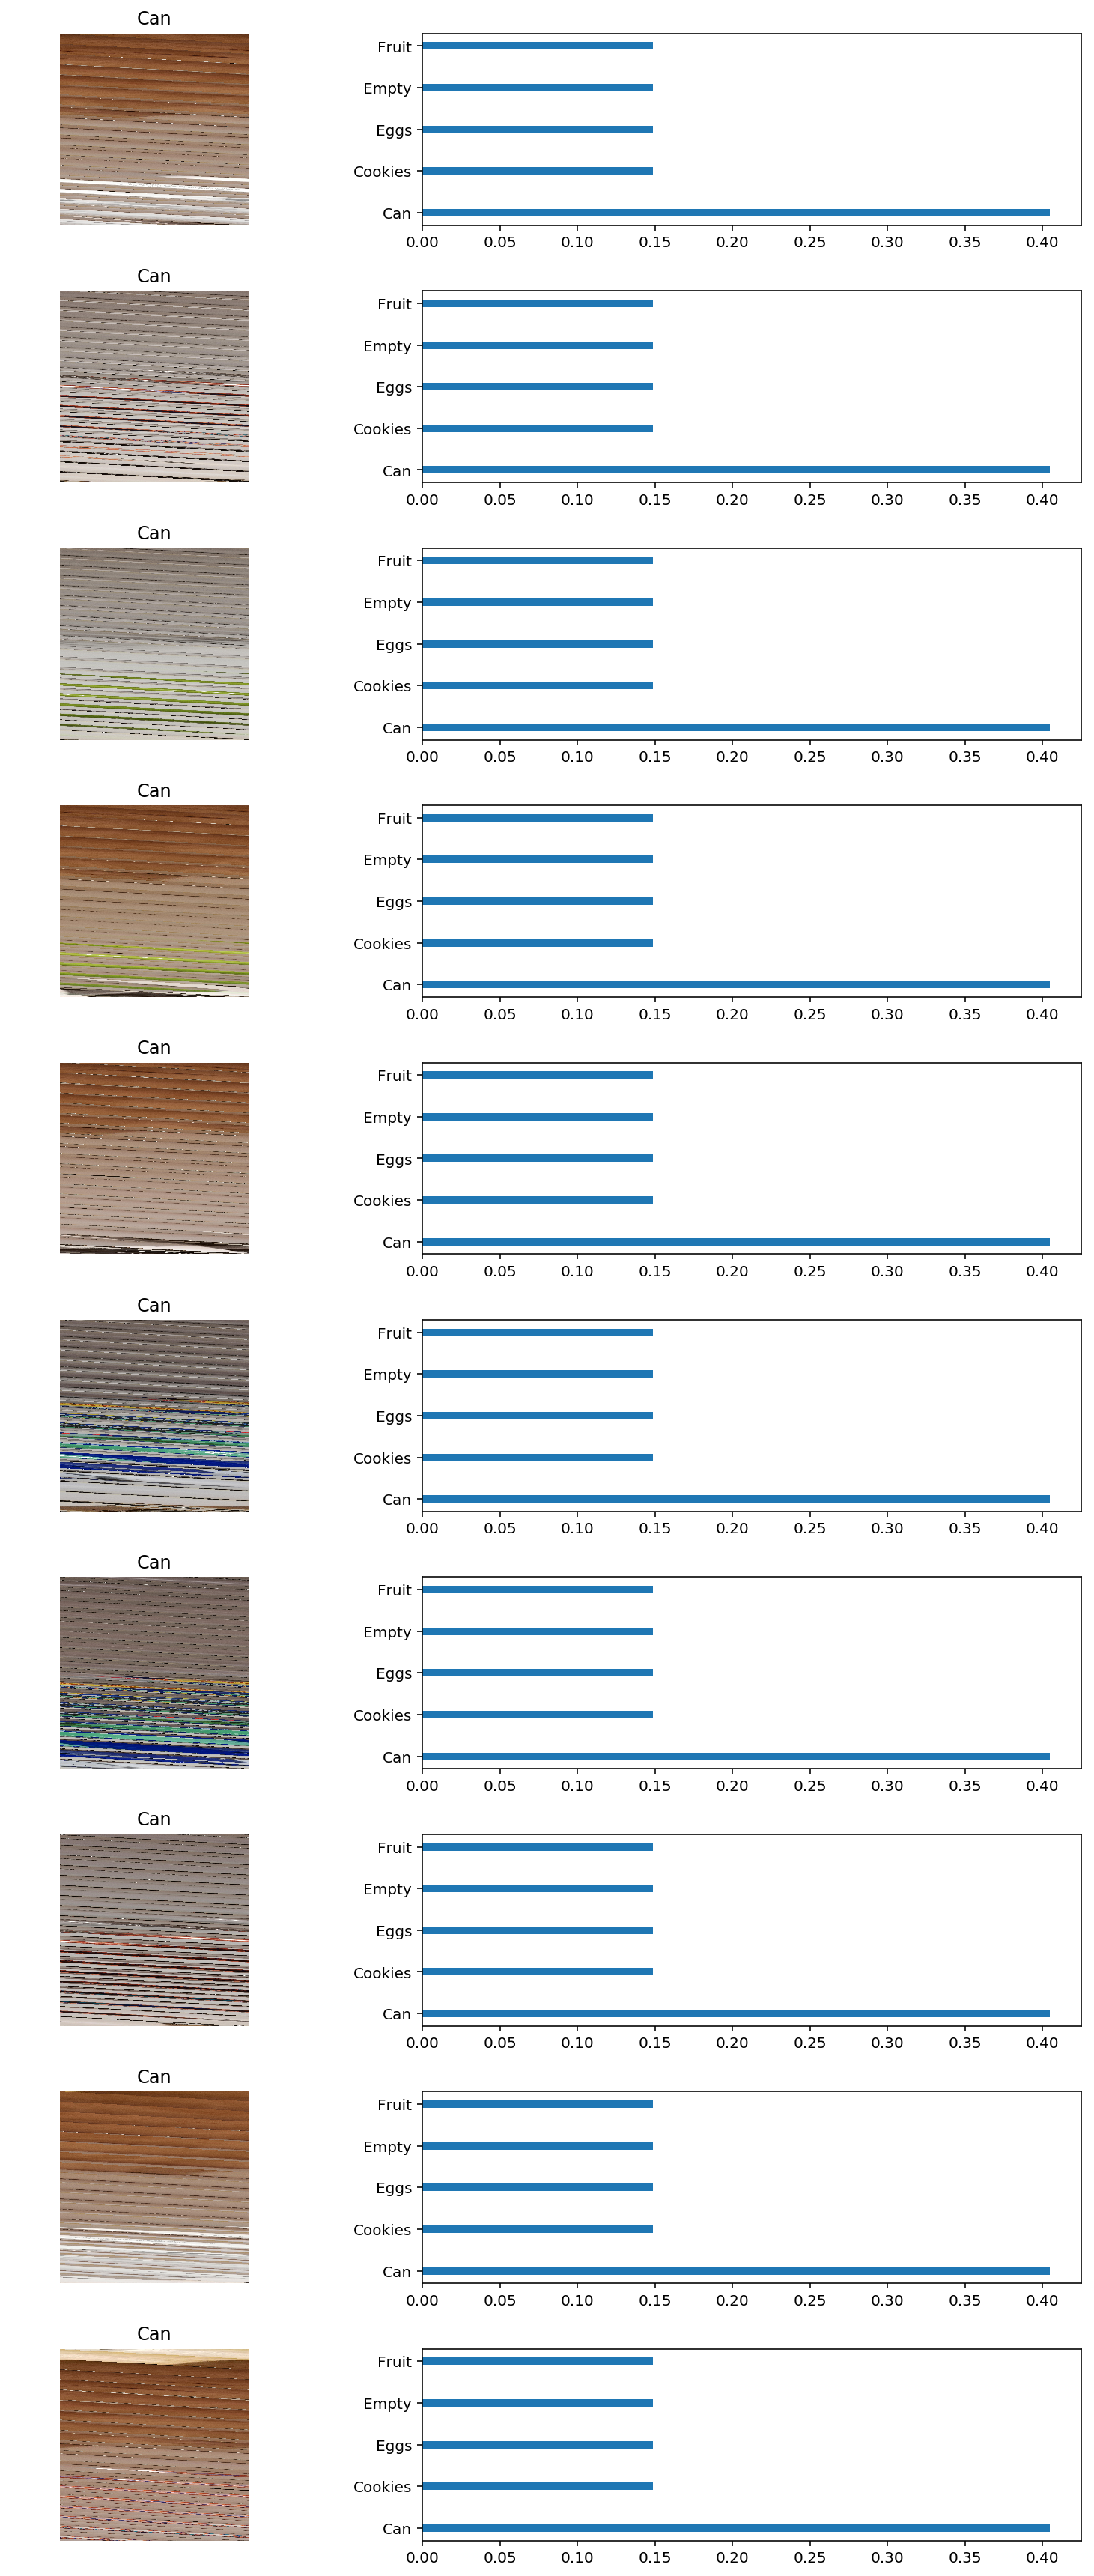

In [20]:


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

save_model_path = './image_classification'
batch_size = 64
n_samples = 10
top_n_predictions = 5

def test_model(tmpFeatures):
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
        loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        for train_feature_batch, train_label_batch in batch_features_labels(tmpFeatures, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        tmpTestFeatures = []
    
        for feature in random_test_features:
            tmpFeature = skimage.transform.resize(feature, (224, 224), mode='constant')
            tmpTestFeatures.append(tmpFeature)
           
        random_test_predictions = sess.run(
            tf.nn.softmax(loaded_logits),
            feed_dict={loaded_x: tmpTestFeatures, loaded_y: random_test_labels})
        
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model(tmpFeatures)



References
https://github.com/deep-diver/CIFAR10-VGG19-Tensorflow/blob/master/CIFAR10-transfer-learning-tensornets.ipynb  
https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4